In [1]:
from IPython.display import Image

# CNTK 105: Basic autoencoder with MNIST data

**Prerequisites**: We assume that you have successfully downloaded the MNIST data by completing the tutorial titled CNTK_103A_MNIST_DataLoader.ipynb.


## Introduction

In this tutorial we introduce you to the basics of [Autoencoders](https://en.wikipedia.org/wiki/Autoencoder). An autoencoder is an artificial neural network used for unsupervised learning of efficient encodings. In other words, they are used for lossy data-specific compression that is learnt automatically instead of relying on human engineered features. The aim of an autoencoder is to learn a representation (encoding) for a set of data, typically for the purpose of dimensionality reduction. 

The autoencoders are very specific to the data-set on hand and are different from standard codecs such as JPEG, MPEG standard based encodings. Once the information is encoded and decoded back to original dimensions some amount of information is lost in the process. Given these encodings are specific to data, autoencoders are not used for compression. However, there are two areas where autoencoders have been found very effective in denoising and  dimensionality reduction.

Autoencoders have attracted attention since they have long been thought to be a potential approach for unsupervised learning. Truly unsupervised approaches involve learning useful representations without the need for labels. Autoencoders fall under self-supervised learning, a specific instance of supervised learning where the targets are generated from the input data. 

**Goal** 

Our goal is to train an autoencoder that compresses MNIST digits image to a vector of smaller dimension and then restores the image. The MNIST data comprises of hand-written digits with little background noise.

In [2]:
# Figure 1
Image(url="http://cntk.ai/jup/MNIST-image.jpg", width=300, height=300)

In this tutorial, we will use the [MNIST hand-written digits data](https://en.wikipedia.org/wiki/MNIST_database) to illustrate encoding the images and decoding (restoring) them using feed-forward networks. We will visualize the original and the restored images. We illustrate feed forward network based both simple autoencoder and deep autoencoder. More advanced autoencoders will be covered in future 200 series tutorials.

In [3]:
# Import the relevant modules
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

# Import CNTK related modules
import cntk as C
from cntk.device import try_set_default_device, gpu, cpu
from cntk.layers import default_options, Dense
from cntk.io import StreamConfiguration, StreamDef, StreamDefs, INFINITELY_REPEAT
from cntk.io import MinibatchSource, CTFDeserializer

%matplotlib inline

### Select the notebook runtime environment devices / settings

Set the device to cpu / gpu for the test environment. If you have both CPU and GPU on your machine, you can optionally switch the devices. By default we choose the best available device.

In [4]:
# Select the right target device when this notebook is being tested:
C.device.try_set_default_device(C.device.gpu(0))

True

There are two run modes:
- *Fast mode*: `isFast` is set to `True`. This is the default mode for the notebooks, which means we train for fewer iterations or train / test on limited data. This ensures functional correctness of the notebook though the models produced are far from what a completed training would produce.

- *Slow mode*: We recommend the user to set this flag to `False` once the user has gained familiarity with the notebook content and wants to gain insight from running the notebooks for a longer period with different parameters for training. 

In [5]:
isFast = True

## Data reading

In this section, we will read the data generated in CNTK 103 Part A.

The data is in the following format:

    |labels 0 0 0 0 0 0 0 1 0 0 |features 0 0 0 0 ... 
                                                  (784 integers each representing a pixel)
    
 In this tutorial we are going to use the image pixels corresponding the integer stream named "features". We define a `create_reader` function to read the training and test data using the [CTF deserializer](https://cntk.ai/pythondocs/cntk.io.html?highlight=ctfdeserializer#cntk.io.CTFDeserializer). The labels are [1-hot encoded](https://en.wikipedia.org/wiki/One-hot). We ignore them in this tutorial. 

We also check if the training and test data file has been downloaded and available for reading by the `create_reader` function. In this tutorial we are using the MNIST data you have downloaded using CNTK_103A_MNIST_DataLoader notebook. The dataset has 60,000 training images and 10,000 test images with each image being 28 x 28 pixels.

In [6]:
# Read a CTF formatted text (as mentioned above) using the CTF deserializer from a file
def create_reader(path, is_training, input_dim, num_label_classes):
    return MinibatchSource(CTFDeserializer(path, StreamDefs(
        labels_viz = StreamDef(field='labels', shape=num_label_classes, is_sparse=False),
        features   = StreamDef(field='features', shape=input_dim, is_sparse=False)
    )), randomize = is_training, max_sweeps = INFINITELY_REPEAT if is_training else 1)

In [7]:
# Ensure the training and test data is generated and available for this tutorial.
# We search in two locations in the toolkit for the cached MNIST data set.
data_found = False
for data_dir in [os.path.join("..", "Examples", "Image", "DataSets", "MNIST"),
                 os.path.join("data", "MNIST")]:
    train_file = os.path.join(data_dir, "Train-28x28_cntk_text.txt")
    test_file = os.path.join(data_dir, "Test-28x28_cntk_text.txt")
    if os.path.isfile(train_file) and os.path.isfile(test_file):
        data_found = True
        break
        
if not data_found:
    raise ValueError("Please generate the data by completing CNTK 103 Part A")
print("Data directory is {0}".format(data_dir))


Data directory is data/MNIST


<a id='#Model Creation'></a>
## Model Creation

We start with a simple single fully-connected feedforward network as encoder and as decoder (as shown in the figure below):

In [8]:
# Figure 2
Image(url="http://cntk.ai/jup/SimpleAEfig.jpg", width=200, height=200)

The input data are a set of hand written digits images each 28 x28 pixels. In this tutorial, we will consider each image as a linear array of 784 pixel values. These pixels are considered as an input having 784 dimensions, one per pixel. Since the goal of the autoencoder is to compress the data and reconstruct the original image, the output dimension is same as the input dimension. We will compress the input to mere 32 dimensions (referred to as the `encoding_dim`). Additionally, since the maximum input value is 255, we normalize the input between 0 and 1. 

In [9]:
input_dim = 784
encoding_dim = 32
output_dim = input_dim

def create_model(features):
    with default_options(init = C.glorot_uniform()):
        # We scale the input pixels to 0-1 range
        encode = Dense(encoding_dim, activation = C.relu)(features/255.0)
        decode = Dense(input_dim, activation = C.sigmoid)(encode)

    return decode

## Setup the network for training and testing

In previous tutorials, we have defined each of the training and testing phases separately. In this tutorial, we combine the two componets in one place such that this template could be used as a recipe for your usage.  

The `train_and_test` function performs two major tasks:
- Train the model
- Evaluate the accuracy of the model on test data

For training:

> The function takes a reader (`reader_train`), a model function (`model_func`) and the target (a.k.a `label`) as input. In this tutorial, we show how to create and pass your **own** loss function. We normalize the `label` function to emit value between 0 and 1 for us to compute the label error using `C.classification_error` function.

> We use Adam optimizer in this tutorial from a range of [learners](https://www.cntk.ai/pythondocs/cntk.learner.html#module-cntk.learner) (optimizers) available in the toolkit.  

For testing:

> The function additionally takes a reader  (`reader_test`) and evaluates the predicted pixel values made by the model against reference data, in this case the original pixel values for each image.


In [10]:
def train_and_test(reader_train, reader_test, model_func):
    
    ###############################################
    # Training the model
    ###############################################
    
    # Instantiate the input and the label variables
    input = C.input(input_dim)
    label = C.input(input_dim)
    
    # Create the model function
    model = model_func(input)
    
    # The labels for this network is same as the input MNIST image.
    # Note: Inside the model we are scaling the input to 0-1 range
    # Hence we rescale the label to the same range
    # We show how one can use their custom loss function
    # loss = -(y* log(p)+ (1-y) * log(1-p)) where p = model output and y = target
    # We have normalized the input between 0-1. Hence we scale the target to same range
    
    target = label/255.0 
    loss = -(target * C.log(model) + (1 - target) * C.log(1 - model))
    label_error  = C.classification_error(model, target)
    
    # training config
    epoch_size = 30000        # 30000 samples is half the dataset size 
    minibatch_size = 64
    num_sweeps_to_train_with = 5 if isFast else 100
    num_samples_per_sweep = 60000
    num_minibatches_to_train = (num_samples_per_sweep * num_sweeps_to_train_with) // minibatch_size
 
    
    # Instantiate the trainer object to drive the model training
    lr_per_sample = [0.00003]
    lr_schedule = C.learning_rate_schedule(lr_per_sample, C.UnitType.sample, epoch_size)
    
    # Momentum
    momentum_as_time_constant = C.momentum_as_time_constant_schedule(700)
    
    # We use a variant of the Adam optimizer which is known to work well on this dataset
    # Feel free to try other optimizers from 
    # https://www.cntk.ai/pythondocs/cntk.learner.html#module-cntk.learner
    learner = C.fsadagrad(model.parameters,
                          lr=lr_schedule, momentum=momentum_as_time_constant) 
    
    # Instantiate the trainer
    progress_printer = C.logging.ProgressPrinter(0)
    trainer = C.Trainer(model, (loss, label_error), learner, progress_printer)
    
    # Map the data streams to the input and labels.
    # Note: for autoencoders input == label
    input_map = {
        input  : reader_train.streams.features,
        label  : reader_train.streams.features
    } 
    
    aggregate_metric = 0
    for i in range(num_minibatches_to_train):
        # Read a mini batch from the training data file
        data = reader_train.next_minibatch(minibatch_size, input_map = input_map)
        
        # Run the trainer on and perform model training
        trainer.train_minibatch(data)
        samples = trainer.previous_minibatch_sample_count
        aggregate_metric += trainer.previous_minibatch_evaluation_average * samples
        
    train_error = (aggregate_metric*100.0) / (trainer.total_number_of_samples_seen)
    print("Average training error: {0:0.2f}%".format(train_error))
        
    #############################################################################
    # Testing the model
    # Note: we use a test file reader to read data different from a training data
    #############################################################################
        
    # Test data for trained model
    test_minibatch_size = 32
    num_samples = 10000
    num_minibatches_to_test = num_samples / test_minibatch_size
    test_result = 0.0
    
    # Test error metric calculation
    metric_numer    = 0
    metric_denom    = 0

    test_input_map = {
        input  : reader_test.streams.features,
        label  : reader_test.streams.features
    }

    for i in range(0, int(num_minibatches_to_test)):
        
        # We are loading test data in batches specified by test_minibatch_size
        # Each data point in the minibatch is a MNIST digit image of 784 dimensions 
        # with one pixel per dimension that we will encode / decode with the 
        # trained model.
        data = reader_test.next_minibatch(test_minibatch_size,
                                       input_map = test_input_map)

        # Specify the mapping of input variables in the model to actual
        # minibatch data to be tested with
        eval_error = trainer.test_minibatch(data)
        
        # minibatch data to be trained with
        metric_numer += np.abs(eval_error * test_minibatch_size)
        metric_denom += test_minibatch_size

    # Average of evaluation errors of all test minibatches
    test_error = (metric_numer*100.0) / (metric_denom) 
    print("Average test error: {0:0.2f}%".format(test_error))
    
    return model, train_error, test_error

Let us train the simple autoencoder. We create a training and a test reader

In [11]:
num_label_classes = 10
reader_train = create_reader(train_file, True, input_dim, num_label_classes)
reader_test = create_reader(test_file, False, input_dim, num_label_classes)
model, simple_ae_train_error, simple_ae_test_error = train_and_test(reader_train, 
                                                                    reader_test, 
                                                                    model_func = create_model )

 average      since    average      since      examples
    loss       last     metric       last              
 ------------------------------------------------------
Learning rate per sample: 3e-05
      544        544       0.93       0.93            64
      544        543      0.937      0.941           192
      543        543      0.953      0.964           448
      542        541      0.938      0.925           960
      537        532      0.928       0.92          1984
      494        452      0.809      0.694          4032
      383        274      0.637      0.468          8128
      303        223      0.526      0.417         16320
      251        200      0.399      0.272         32704
      210        168      0.283      0.167         65472
      175        139      0.195      0.107        131008
      144        113      0.125     0.0553        262080
Average training error: 11.37%
Average test error: 3.05%


### Visualize the simple autoencoder results

In [12]:
# Read some data to run the eval
num_label_classes = 10
reader_eval = create_reader(test_file, False, input_dim, num_label_classes)

eval_minibatch_size = 50
eval_input_map = { input  : reader_eval.streams.features }    
    
eval_data = reader_eval.next_minibatch(eval_minibatch_size,
                                  input_map = eval_input_map)

img_data = eval_data[input].asarray()

# Select a random image
np.random.seed(0) 
idx = np.random.choice(eval_minibatch_size)

orig_image = img_data[idx,:,:]
decoded_image = model.eval(orig_image)[0]*255

# Print image statistics
def print_image_stats(img, text):
    print(text)
    print("Max: {0:.2f}, Median: {1:.2f}, Mean: {2:.2f}, Min: {3:.2f}".format(np.max(img),
                                                                              np.median(img),
                                                                              np.mean(img),
                                                                              np.min(img))) 
    
# Print original image
print_image_stats(orig_image, "Original image statistics:")

# Print decoded image
print_image_stats(decoded_image, "Decoded image statistics:")


Original image statistics:
Max: 255.00, Median: 0.00, Mean: 24.07, Min: 0.00
Decoded image statistics:
Max: 249.48, Median: 0.57, Mean: 27.13, Min: 0.00


Let us plot the original and the decoded image. They should look visually similar.

In [13]:
# Define a helper function to plot a pair of images
def plot_image_pair(img1, text1, img2, text2):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 6))

    axes[0].imshow(img1, cmap="gray")
    axes[0].set_title(text1)
    axes[0].axis("off")

    axes[1].imshow(img2, cmap="gray")
    axes[1].set_title(text2)
    axes[1].axis("off")

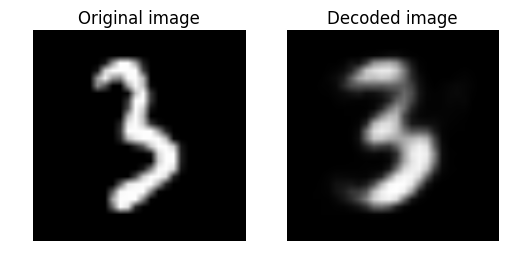

In [14]:
# Plot the original and the decoded image
img1 = orig_image.reshape(28,28)
text1 = 'Original image'

img2 = decoded_image.reshape(28,28)
text2 = 'Decoded image'

plot_image_pair(img1, text1, img2, text2)

## Deep Auto encoder

We do not have to limit ourselves to a single layer as encoder or decoder, we could instead use a stack of dense layers. Let us create a deep autoencoder.

In [15]:
# Figure 3
Image(url="http://cntk.ai/jup/DeepAEfig.jpg", width=500, height=300)

The encoding dimensions are 128, 64 and 32 while the decoding dimensions are symmetrically opposite 64, 128 and 784. This increases the number of parameters used to model the transformation and achieves lower error rates at the cost of longer training duration and memory footprint. If we train this deep encoder for larger number iterations by turning the `isFast` flag to be `False`, we get a lower error and the reconstructed images are also marginally better. 

In [16]:
input_dim = 784
encoding_dims = [128,64,32]
decoding_dims = [64,128]

encoded_model = None

def create_deep_model(features):
    with default_options(init = C.glorot_uniform()):
        encode = C.element_times(C.constant(1.0/255.0), features)

        for encoding_dim in encoding_dims:
            encode = Dense(encoding_dim, activation = C.relu)(encode)

        global encoded_model
        encoded_model= encode
        
        decode = encode
        for decoding_dim in decoding_dims:
            decode = Dense(decoding_dim, activation = C.relu)(decode)

        decode = Dense(input_dim, activation = C.sigmoid)(decode)
        return decode  

In [17]:
num_label_classes = 10
reader_train = create_reader(train_file, True, input_dim, num_label_classes)
reader_test = create_reader(test_file, False, input_dim, num_label_classes)

model, deep_ae_train_error, deep_ae_test_error = train_and_test(reader_train, 
                                                                reader_test, 
                                                                model_func = create_deep_model) 

 average      since    average      since      examples
    loss       last     metric       last              
 ------------------------------------------------------
Learning rate per sample: 3e-05
      543        543      0.787      0.787            64
      543        543      0.773      0.766           192
      543        543      0.761      0.752           448
      542        541      0.734      0.711           960
      528        515      0.657      0.584          1984
      412        301      0.576      0.497          4032
      314        217      0.529      0.483          8128
      259        205      0.466      0.405         16320
      218        178      0.363      0.259         32704
      180        142      0.259      0.156         65472
      149        117      0.175     0.0904        131008
      124       99.4      0.115     0.0545        262080
Average training error: 10.54%
Average test error: 3.42%


### Visualize the deep autoencoder results

In [18]:
# Run the same image as the simple autoencoder through the deep encoder
orig_image = img_data[idx,:,:]
decoded_image = model.eval(orig_image)[0]*255

# Print image statistics
def print_image_stats(img, text):
    print(text)
    print("Max: {0:.2f}, Median: {1:.2f}, Mean: {2:.2f}, Min: {3:.2f}".format(np.max(img),
                                                                              np.median(img),
                                                                              np.mean(img),
                                                                              np.min(img))) 
    
# Print original image
print_image_stats(orig_image, "Original image statistics:")

# Print decoded image
print_image_stats(decoded_image, "Decoded image statistics:")


Original image statistics:
Max: 255.00, Median: 0.00, Mean: 24.07, Min: 0.00
Decoded image statistics:
Max: 253.10, Median: 0.01, Mean: 22.60, Min: 0.00


Let us plot the original and the decoded image with the deep autoencoder. They should look visually similar.

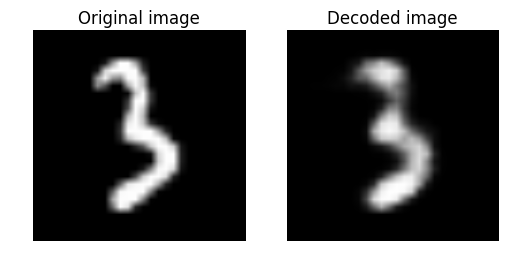

In [19]:
# Plot the original and the decoded image
img1 = orig_image.reshape(28,28)
text1 = 'Original image'

img2 = decoded_image.reshape(28,28)
text2 = 'Decoded image'

plot_image_pair(img1, text1, img2, text2)

We have shown how to encode and decode an input. In this section we will explore how we can compare one to another and also show how to extract an encoded input for a given input. For visualizing high dimension data in 2D, [t-SNE](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) is probably one of the best methods. However, it typically requires relatively low-dimensional data. So a good strategy for visualizing similarity relationships in high-dimensional data is to encode data into a low-dimensional space (e.g. 32 dimensional) using an autoencoder first, extract the encoding of the input data followed by using t-SNE for mapping the compressed data to a 2D plane. 

We will use the deep autoencoder outputs to:
- Compare two images and
- Show how we can retrieve an encoded (compressed) data. 

First we need to read some image data along with their labels. 

In [20]:
# Read some data to run get the image data and the corresponding labels
num_label_classes = 10
reader_viz = create_reader(test_file, False, input_dim, num_label_classes)

image = C.input(input_dim)
image_label = C.input(num_label_classes)

viz_minibatch_size = 50

viz_input_map = { 
    image  : reader_viz.streams.features, 
    image_label  : reader_viz.streams.labels_viz 
}    
    
viz_data = reader_eval.next_minibatch(viz_minibatch_size,
                                  input_map = viz_input_map)

img_data   = viz_data[image].asarray()
imglabel_raw = viz_data[image_label].asarray()

In [21]:
# Map the image labels into indices in minibatch array
img_labels = [np.argmax(imglabel_raw[i,:,:]) for i in range(0, imglabel_raw.shape[0])]       
        
from collections import defaultdict
label_dict=defaultdict(list)
for img_idx, img_label, in enumerate(img_labels):
    label_dict[img_label].append(img_idx)        
    
# Print indices corresponding to 3 digits
randIdx = [1, 3, 9]
for i in randIdx:
    print("{0}: {1}".format(i, label_dict[i]))

1: [7, 24, 39, 44, 46]
3: [1, 13, 18, 26, 37, 40, 43]
9: [8, 12, 23, 28, 42, 49]


We will [compute cosine distance](https://en.wikipedia.org/wiki/Cosine_similarity) between two images using `scipy`. 

In [22]:
from scipy import spatial

def image_pair_cosine_distance(img1, img2):
    if img1.size != img2.size:
        raise ValueError("Two images need to be of same dimension")
    return 1 - spatial.distance.cosine(img1, img2)

Distance between two original image: 0.294
Distance between two decoded image: 0.307


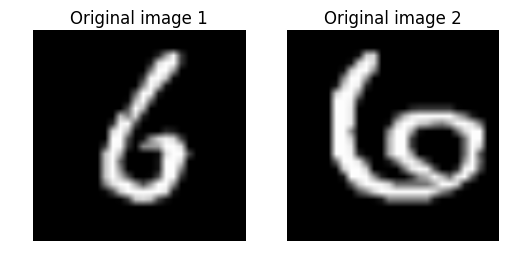

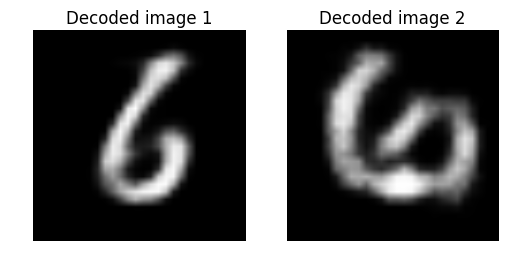

In [23]:
# Let s compute the distance between two images of the same number
digit_of_interest = 6

digit_index_list = label_dict[digit_of_interest]

if len(digit_index_list) < 2:
    print("Need at least two images to compare")
else:
    imgA = img_data[digit_index_list[0],:,:][0] 
    imgB = img_data[digit_index_list[1],:,:][0]
    
    # Print distance between original image
    imgA_B_dist = image_pair_cosine_distance(imgA, imgB)
    print("Distance between two original image: {0:.3f}".format(imgA_B_dist))
    
    # Plot the two images
    img1 = imgA.reshape(28,28)
    text1 = 'Original image 1'

    img2 = imgB.reshape(28,28)
    text2 = 'Original image 2'

    plot_image_pair(img1, text1, img2, text2)
    
    # Decode the encoded stream 
    imgA_decoded =  model.eval([imgA])[0]
    imgB_decoded =  model.eval([imgB])   [0]    
    imgA_B_decoded_dist = image_pair_cosine_distance(imgA_decoded, imgB_decoded)

    # Print distance between original image
    print("Distance between two decoded image: {0:.3f}".format(imgA_B_decoded_dist))
    
    # Plot the two images
    # Plot the original and the decoded image
    img1 = imgA_decoded.reshape(28,28)
    text1 = 'Decoded image 1'

    img2 = imgB_decoded.reshape(28,28)
    text2 = 'Decoded image 2'

    plot_image_pair(img1, text1, img2, text2)


Note: The cosine distance between the original images comparable to the distance between the corresponding decoded images. A value of 1 indicates high similarity between the images and 0 indicates no similarity.

Let us now see how to get the encoded vector corresponding to an input image. This should have the dimension of the choke point in the network shown in the figure with the box labeled `E`.

In [24]:
imgA = img_data[digit_index_list[0],:,:][0] 
imgA_encoded =  encoded_model.eval([imgA])

print("Length of the original image is {0:3d} and the encoded image is {1:3d}".format(len(imgA), 
                                                                                      len(imgA_encoded[0])))
print("\nThe encoded image: ")
print(imgA_encoded[0])

Length of the original image is 784 and the encoded image is  32

The encoded image: 
[ 10.33654404   0.           4.4243474    5.80089092  18.11969757
   7.14934969  14.9536972    0.           6.4275465   14.54602814
   4.45022869   0.           5.96359777   0.          17.45487976   0.
  19.41970825  18.70067406   9.1056757   11.37087536   7.79232311   0.
   1.20848584  11.41752434   7.14730024   9.20821857   6.70220709
  21.23435402   8.56841755  12.37904072  21.98976135   9.65566921]


Let us compare the distance between different digits.

Distance between two original image: 0.376
Distance between two decoded image: 0.415


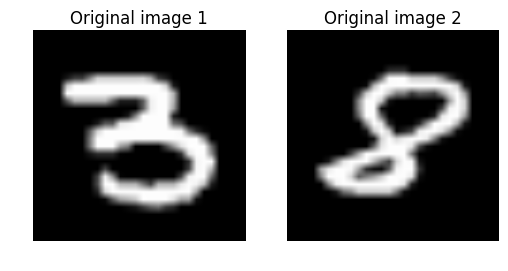

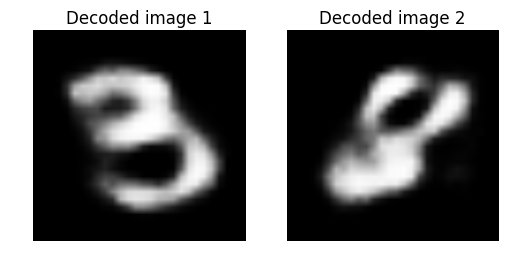

In [25]:
digitA = 3
digitB = 8

digitA_index = label_dict[digitA]
digitB_index = label_dict[digitB]

imgA = img_data[digitA_index[0],:,:][0] 
imgB = img_data[digitB_index[0],:,:][0]

# Print distance between original image
imgA_B_dist = image_pair_cosine_distance(imgA, imgB)
print("Distance between two original image: {0:.3f}".format(imgA_B_dist))
    
# Plot the two images
img1 = imgA.reshape(28,28)
text1 = 'Original image 1'

img2 = imgB.reshape(28,28)
text2 = 'Original image 2'

plot_image_pair(img1, text1, img2, text2)
    
# Decode the encoded stream 
imgA_decoded =  model.eval([imgA])[0]
imgB_decoded =  model.eval([imgB])[0]    
imgA_B_decoded_dist = image_pair_cosine_distance(imgA_decoded, imgB_decoded)

#Print distance between original image
print("Distance between two decoded image: {0:.3f}".format(imgA_B_decoded_dist))

# Plot the original and the decoded image
img1 = imgA_decoded.reshape(28,28)
text1 = 'Decoded image 1'

img2 = imgB_decoded.reshape(28,28)
text2 = 'Decoded image 2'

plot_image_pair(img1, text1, img2, text2)

Print the results of the deep encoder test error for regression testing

In [26]:
# Simple autoencoder test error
print(simple_ae_test_error)

3.04915905178


In [27]:
# Deep autoencoder test error
print(deep_ae_test_error)

3.42422972302


## Suggested tasks

- Try different activation functions.
- Find which images are more similar to one another (a) using original image and (b) decoded image.
- Try using mean square error as the loss function. Does it improve the performance of the encoder in terms of reduced errors.
- Can you try different network structure to reduce the error further. Explain your observations.
- Can you use a different distance metric to compute similarity between the MNIST images.
- Try a deep encoder with [1000, 500, 250, 128, 64, 32]. What is the training error for same number of iterations? 